In [1]:
%load_ext autoreload
%autoreload 2   

Epoch 0, Loss: 1.3848
Epoch 20, Loss: 1.0288
Epoch 40, Loss: 1.0972
Epoch 60, Loss: 0.8134
Epoch 80, Loss: 0.9261
Epoch 100, Loss: 0.8264
Epoch 120, Loss: 0.9031
Epoch 140, Loss: 0.8290
Epoch 160, Loss: 0.8329
Epoch 180, Loss: 1.0257


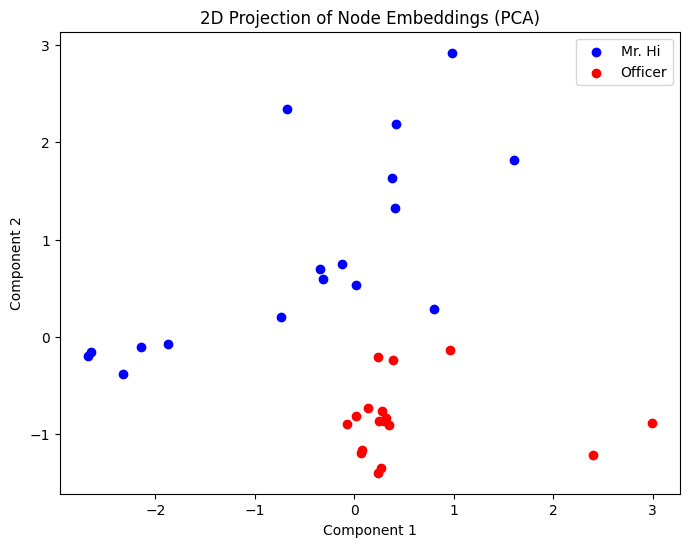

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import binary_cross_entropy_with_logits


# GCN Layer
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GCNLayer, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_dim, out_dim))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, h, adj):
        h = torch.mm(h, self.weight)
        h = torch.mm(adj, h)
        return h


# GNN Encoder
class GNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(GNNEncoder, self).__init__()
        self.layer1 = GCNLayer(input_dim, hidden_dim)
        self.layer2 = GCNLayer(hidden_dim, hidden_dim)
        self.layer3 = GCNLayer(hidden_dim, embedding_dim)
        self.activation = nn.ReLU()

    def forward(self, x, adj):
        h = self.activation(self.layer1(x, adj))
        h = self.activation(self.layer2(h, adj))
        h = self.layer3(h, adj)  # No activation on last layer for embeddings
        return h


# Load Zachary's Karate Club dataset
def load_karate_club():
    g = nx.karate_club_graph()
    N = g.number_of_nodes()
    A = nx.to_numpy_array(g)
    A = A + np.eye(N)  # Add self-loops
    degrees = np.sum(A, axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(degrees))
    adj_hat = D_inv_sqrt @ A @ D_inv_sqrt
    adj = torch.FloatTensor(adj_hat)
    x = torch.eye(N)  # One-hot features
    # Get positive edges
    pos_edges = np.array(g.edges())
    # Get labels for visualization (Mr. Hi = 0, Officer = 1)
    labels = [0 if g.nodes[n]["club"] == "Mr. Hi" else 1 for n in range(N)]
    return x, adj, pos_edges, np.array(labels), N


# Negative sampling
def sample_negative_edges(pos_edges, N, num_samples):
    neg_edges = []
    while len(neg_edges) < num_samples:
        u, v = np.random.randint(0, N, 2)
        if (
            u != v
            and [u, v] not in pos_edges.tolist()
            and [v, u] not in pos_edges.tolist()
        ):
            neg_edges.append([u, v])
    return np.array(neg_edges)


# Decoder: compute logit (dot product)
def decode(z, edges):
    return torch.sum(z[edges[:, 0]] * z[edges[:, 1]], dim=1)


# Training
def train():
    x, adj, pos_edges, labels, N = load_karate_club()
    model = GNNEncoder(input_dim=N, hidden_dim=32, embedding_dim=16)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    num_pos = len(pos_edges)
    pos_edges_tensor = torch.LongTensor(pos_edges)

    for epoch in range(200):
        model.train()
        optimizer.zero_grad()

        z = model(x, adj)

        # Positive logits
        pos_logits = decode(z, pos_edges_tensor)

        # Sample negatives
        neg_edges = sample_negative_edges(pos_edges, N, num_pos)
        neg_edges_tensor = torch.LongTensor(neg_edges)
        neg_logits = decode(z, neg_edges_tensor)

        # Labels: 1 for pos, 0 for neg
        pos_labels = torch.ones(num_pos)
        neg_labels = torch.zeros(num_pos)

        # Loss
        loss = binary_cross_entropy_with_logits(
            pos_logits, pos_labels
        ) + binary_cross_entropy_with_logits(neg_logits, neg_labels)

        loss.backward()
        optimizer.step()

        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return model, x, adj, labels


# Inference: Generate embeddings
def inference(model, x, adj):
    model.eval()
    with torch.no_grad():
        z = model(x, adj)
    return z.numpy()


# Visualisation: Project to 2D with PCA and plot
def visualize_embeddings(z, labels):
    # Simple PCA implementation using SVD
    z_mean = np.mean(z, axis=0)
    z_centered = z - z_mean
    U, S, Vt = np.linalg.svd(z_centered, full_matrices=False)
    z_2d = U[:, :2] * S[:2]

    plt.figure(figsize=(8, 6))
    plt.scatter(z_2d[labels == 0, 0], z_2d[labels == 0, 1], label="Mr. Hi", c="blue")
    plt.scatter(z_2d[labels == 1, 0], z_2d[labels == 1, 1], label="Officer", c="red")
    plt.legend()
    plt.title("2D Projection of Node Embeddings (PCA)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()


# Run everything
if __name__ == "__main__":
    model, x, adj, labels = train()
    z = inference(model, x, adj)
    visualize_embeddings(z, labels)